# Plans
- Read data and see some examples
- Create data loader
- Create a simple early fusion model for train
- Train and single example inference
- create a explain model
- Single example explain

# Setup

In [124]:
!pip install transformers

In [125]:
import os
import json
import matplotlib.pyplot as plt
import cv2
import shutil
from PIL import Image
import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import vgg19

import transformers
from transformers import BertModel, BertTokenizer

In [126]:
# Global Path Vairables
ROOT_DIR =  "drive/MyDrive/11877-AMMML/dataset/"
DATASET_DIR = ROOT_DIR + "hateful_memes/"

In [127]:
def get_all_files_from_dir(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        file_paths += [os.path.join(root, x) for x in files]
    return sorted(file_paths)

In [128]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Exploratory Data Analysis

In [129]:
train_raw_json_list = []
with open(DATASET_DIR + "train.jsonl", "r") as f:
  for json_string in list(f):
    train_raw_json_list.append(json.loads(json_string))

In [143]:
image_paths = [x["img"] for x in train_raw_json_list]

# # Filter out images whose dimension is less than 224
# filter_image_list = []
# for i in range(len(image_paths)):
#   PIL_image = Image.open(DATASET_DIR + train_raw_json_list[i]["img"])
#   if PIL_image.size[0] < 224 or PIL_image.size[1] < 224:
#     filter_image_list.append(train_raw_json_list[i]["img"])
#     print(train_raw_json_list[i]["img"])
#   if i % 50 == 0:
#     print(i)

filter_image_list = ['img/80567.png', 'img/49270.png', 'img/58306.png', 'img/17832.png', 'img/17205.png', 'img/75428.png', 'img/42015.png', 'img/38624.png', 'img/30847.png', 'img/07312.png', 'img/74589.png', 'img/86159.png', 'img/51304.png', 'img/18296.png', 'img/69807.png', 'img/65908.png', 'img/65940.png', 'img/79854.png', 'img/93124.png', 'img/36725.png', 'img/94802.png', 'img/21043.png', 'img/09478.png', 'img/73984.png', 'img/59248.png', 'img/98412.png', 'img/26543.png', 'img/96701.png', 'img/86104.png', 'img/48579.png', 'img/84076.png', 'img/42073.png', 'img/98367.png', 'img/56193.png', 'img/41823.png', 'img/85269.png', 'img/16702.png', 'img/82156.png', 'img/90483.png', 'img/40158.png', 'img/17928.png', 'img/32781.png', 'img/58194.png', 'img/82540.png', 'img/36178.png', 'img/94150.png', 'img/16084.png', 'img/95817.png', 'img/16438.png', 'img/85147.png', 'img/65904.png', 'img/85392.png', 'img/43791.png', 'img/69025.png', 'img/79423.png', 'img/49067.png', 'img/84951.png', 'img/25310.png', 'img/23174.png', 'img/96340.png', 'img/98736.png', 'img/08741.png', 'img/10835.png', 'img/48192.png', 'img/40917.png']
image_paths = [item for item in image_paths if item not in filter_image_list]

labels = [x["label"] for x in train_raw_json_list if x["img"] not in filter_image_list]
texts = [x["text"] for x in train_raw_json_list if x["img"] not in filter_image_list]

(366, 550, 3)
img/70294.png
men that say they don't like a big fat booty probably prefer a big fat cock
0


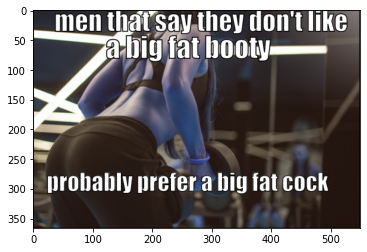

In [144]:
index = 1300
cv2_image = cv2.imread(DATASET_DIR + train_raw_json_list[index]["img"])
print(cv2_image.shape)
print(train_raw_json_list[index]["img"])
print(train_raw_json_list[index]["text"])
print(train_raw_json_list[index]["label"])
plt.imshow(cv2_image)
plt.show()

In [151]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        super(ImageDataset, self).__init__()
        self.image_paths = [DATASET_DIR + x for x in image_paths]
        self.transform = transform
        self.idx_to_path = {i: image_path for i, image_path in enumerate(self.image_paths)}
        self.path_to_idx = {image_path: i for i, image_path in enumerate(self.image_paths)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_filepath = self.idx_to_path[idx]
        image = Image.open(image_filepath)
        if self.transform:
          try:
            image = self.transform(image)
          except:
            print(image_filepath)
        # return image, image_filepath
        return image
    
    def get_by_path(self, path):
      image, _ =  self.__getitem__(self.path_to_idx[path])
      image = image[None, :]
      return image

In [152]:
# use the ImageNet transformation
imagenet_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

# Already double checked the order of ids in dataset and loader objects are as expected
image_dataset = ImageDataset(image_paths, imagenet_transform)
image_dataloader = DataLoader(dataset=image_dataset, batch_size=4)

In [153]:
class TextDataset(Dataset):
  def __init__(self, texts, targets, tokenizer, max_len):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text = str(self.texts[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      # pad_to_max_length=True,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [154]:
text_dataset = TextDataset(
    texts=texts,
    targets=labels,
    tokenizer=tokenizer,
    max_len=160
  )

text_dataloader = DataLoader(dataset=text_dataset, batch_size=4)

In [157]:
assert len(image_dataloader) == len(text_dataloader)

In [158]:
class MultimodalClassifier(nn.Module):
  def __init__(self, n_classes):
    super(MultimodalClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.vgg = vgg19(pretrained=True)
    self.features_conv = self.vgg.features[:36]
    self.features_final = self.vgg.classifier[:-1]
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    
    self.drop = nn.Dropout(p=0.3)
    self.combined_fc1 = nn.Linear(self.bert.config.hidden_size + 4096, 256)
    self.combined_fc2 = nn.Linear(256, n_classes)
  
  def forward(self, x, input_ids, attention_mask):
    x = self.features_conv(x)
    x = self.max_pool(x)
    x = x.view((x.size(0), -1))
    x = self.features_final(x)

    last_hidden_state, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    ) 

    combined = torch.cat((x, pooled_output), 1)
    combined = F.relu(self.combined_fc1(combined))
    combined = F.relu(self.combined_fc2(combined))

    return combined


In [159]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Currently using device: {}\n".format(DEVICE))

model = MultimodalClassifier(n_classes=1)
model = model.to(DEVICE)
# print("Model Architecture {}\n".format(model))

Currently using device: cuda



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [160]:
EPOCHS = 1
LEARNING_RATE=2e-5

In [161]:
criterion = nn.BCEWithLogitsLoss() # this means the sigmoid is INCORPORATED into the loss!!
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [163]:
print("Training Started...")
model.train()


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for text_features, image_features in zip(text_dataloader, image_dataloader):
    input_ids = text_features["input_ids"].to(DEVICE)
    attention_masks = text_features["attention_mask"].to(DEVICE)
    targets = text_features["targets"].to(DEVICE)
    image_features = image_features.to(DEVICE)

    model.zero_grad()
    output = model(image_features, input_ids, attention_masks)
    loss = criterion(torch.round(torch.sigmoid(output.squeeze())), targets.float())
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(), CLIP)
    optimizer.step()
    
    with torch.no_grad():
      acc = torch.abs(torch.round(torch.sigmoid(output.squeeze())) - targets.float()).view(-1)
      acc = (1. - acc.sum() / acc.size()[0])
      total_acc_train += acc.item()
      total_loss_train += loss.item()
    
  train_acc = total_acc_train / len(text_dataloader)
  train_loss = total_loss_train / len(text_dataloader)
  print("Epoch:", epoch)
  print("Train accuracy:", train_acc)
  print("Train loss", train_loss)
  print()




Training Started...
Epoch: 0
Train accuracy: tensor(0.6112, device='cuda:0')
Train loss 0.7210684702994418



In [ ]:
# class MultimodalExplainer(nn.Module):
#   def __init__(self, n_classes):
#     super(MultimodalExplainer, self).__init__()
#     self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#     self.vgg = vgg19(pretrained=True)
#     self.features_conv = self.vgg.features[:36]
#     self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#     self.drop = nn.Dropout(p=0.3)
#     self.combined_fc1 = nn.Linear(self.bert.config.hidden_size + 4096, 256)
#     self.combined_fc2 = nn.Linear(256, n_classes)
  
#   def forward(self, x, input_ids, attention_mask):
#     x = self.features_conv(x)
#     x = self.max_pool(x)
#     x = x.view((1, -1))
    
#     for module_pos, module in self.bert._modules.items():
#       if module_pos == "embeddings":
#         y = module(input_ids=input_ids)
#         # h = y.register_hook(self.activations_hook)
#       elif module_pos == "encoder":
#         print(y.shape)
#         y = module(hidden_states=y, attention_mask=attention_mask, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None).last_hidden_state
#       else:
#         pooled_output = module(hidden_states=y)
#         last_hidden_state = y
    
#     combined = torch.cat((x, pooled_output), 1)
#     combined = F.relu(self.combined_fc1(combined))
#     combined = F.relu(self.combined_fc2(combined))

#     return combined
